In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/TrueCue/'

Mounted at /content/drive
/content/drive/My Drive/TrueCue


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Bar charts of the number of countries in each '14-day new case rate' group over time
Countries with a population over 5M

In [3]:
df=pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

df_pvt=df.pivot(index='date', columns='iso_code', values='new_cases').fillna(0.)
df_pvt.tail()

#sorted list of countries with a population over 5M
ctries=df[df.date=='2020-10-16'][df.population>=5000000][['iso_code', 'population']].sort_values('population', ascending=False).iso_code.to_list()[1:]
ctries[:10]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


['CHN', 'IND', 'USA', 'IDN', 'PAK', 'BRA', 'NGA', 'BGD', 'RUS', 'MEX']

In [4]:
df_pvt[ctries].tail()

iso_code,CHN,IND,USA,IDN,PAK,BRA,NGA,BGD,RUS,MEX,JPN,ETH,PHL,EGY,VNM,COD,TUR,IRN,DEU,THA,GBR,FRA,ITA,TZA,ZAF,MMR,KEN,KOR,COL,ESP,UGA,ARG,DZA,SDN,UKR,IRQ,AFG,POL,CAN,MAR,...,HTI,CUB,SSD,DOM,CZE,GRC,JOR,PRT,AZE,SWE,HND,ARE,HUN,TJK,BLR,AUT,PNG,ISR,CHE,TGO,SLE,LAO,PRY,BGR,LBY,LBN,SRB,NIC,KGZ,SLV,SGP,DNK,FIN,COG,SVK,NOR,OMN,PSE,CRI,LBR
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-20,34.0,46790.0,60160.0,3373.0,0.0,15383.0,118.0,1637.0,15982.0,3699.0,353.0,723.0,2551.0,123.0,6.0,0.0,2026.0,4251.0,6868.0,9.0,18803.0,13243.0,9337.0,0.0,1461.0,1180.0,195.0,58.0,6311.0,13873.0,101.0,12982.0,214.0,6.0,5469.0,4044.0,87.0,7482.0,3289.0,2117.0,...,51.0,38.0,5.0,320.0,8077.0,432.0,1364.0,1949.0,331.0,772.0,956.0,915.0,989.0,40.0,592.0,1054.0,0.0,1030.0,8737.0,14.0,1.0,0.0,728.0,1024.0,1159.0,658.0,122.0,0.0,384.0,0.0,4.0,452.0,131.0,0.0,860.0,320.0,641.0,543.0,1561.0,4.0
2020-10-21,16.0,54044.0,58549.0,3602.0,1292.0,23227.0,72.0,1383.0,16319.0,5788.0,453.0,630.0,1606.0,158.0,1.0,14.0,1894.0,5039.0,7595.0,9.0,21330.0,20468.0,10871.0,0.0,1050.0,1297.0,571.0,91.0,8256.0,16973.0,97.0,16337.0,223.0,27.0,0.0,3920.0,88.0,9291.0,2251.0,3254.0,...,0.0,47.0,0.0,306.0,11984.0,667.0,2035.0,1876.0,584.0,1293.0,851.0,1077.0,1423.0,41.0,619.0,1803.0,0.0,1627.0,3008.0,33.0,5.0,0.0,621.0,1336.0,957.0,1392.0,326.0,81.0,549.0,309.0,6.0,529.0,294.0,0.0,705.0,147.0,439.0,513.0,847.0,3.0
2020-10-22,22.0,55839.0,62978.0,4267.0,736.0,24818.0,37.0,1542.0,15700.0,6845.0,591.0,628.0,1468.0,178.0,4.0,0.0,2013.0,5616.0,11287.0,10.0,26687.0,26676.0,15199.0,0.0,2055.0,1194.0,497.0,119.0,7561.0,20986.0,145.0,18326.0,252.0,0.0,6719.0,3667.0,135.0,10040.0,2672.0,3577.0,...,3.0,63.0,23.0,425.0,14969.0,865.0,2648.0,2535.0,714.0,1575.0,846.0,1538.0,2032.0,39.0,733.0,2355.0,2.0,832.0,5596.0,16.0,1.0,1.0,746.0,1472.0,719.0,1241.0,512.0,0.0,547.0,145.0,12.0,630.0,222.0,0.0,2202.0,168.0,451.0,569.0,1503.0,1.0
2020-10-23,29.0,54366.0,72058.0,4432.0,736.0,24858.0,138.0,1696.0,15971.0,6612.0,614.0,575.0,1645.0,177.0,3.0,31.0,2102.0,5471.0,11242.0,8.0,21238.0,41622.0,16078.0,0.0,2156.0,1312.0,1068.0,155.0,8570.0,19851.0,108.0,16325.0,266.0,0.0,7053.0,3899.0,116.0,12107.0,2788.0,4151.0,...,0.0,53.0,2.0,475.0,14150.0,882.0,2821.0,3270.0,825.0,1255.0,431.0,1578.0,2066.0,40.0,738.0,2570.0,0.0,1237.0,4968.0,19.0,3.0,0.0,707.0,1595.0,995.0,1450.0,416.0,0.0,582.0,142.0,8.0,760.0,184.0,0.0,1728.0,193.0,353.0,506.0,1191.0,0.0
2020-10-24,33.0,53370.0,85329.0,4369.0,847.0,30026.0,77.0,1586.0,17340.0,6604.0,697.0,536.0,1911.0,170.0,0.0,25.0,2165.0,6134.0,14714.0,4.0,20531.0,42032.0,19143.0,0.0,1897.0,1357.0,631.0,77.0,8672.0,0.0,122.0,15718.0,273.0,0.0,7517.0,3785.0,61.0,13632.0,2584.0,3685.0,...,36.0,58.0,4.0,511.0,15258.0,841.0,2489.0,2899.0,803.0,0.0,373.0,1563.0,1820.0,42.0,787.0,3442.0,0.0,268.0,6592.0,23.0,3.0,0.0,733.0,1589.0,764.0,1452.0,579.0,0.0,556.0,159.0,10.0,859.0,219.0,0.0,2581.0,268.0,0.0,513.0,1210.0,8.0


In [5]:
df_14_day=pd.DataFrame()
for col in df_pvt[ctries].columns:
  df_14_day[col]=df_pvt[col].rolling(window=14).sum()

df_14_day.fillna(0., inplace=True)

for col in df_14_day.columns:
  popn=(df.loc[(df.date=='2020-10-01') & (df.iso_code==col), 'population']/100000).values
  if len(popn) > 0:
    df_14_day[col]=df_14_day[col]/popn
  else:
    print (col)

df_14_day = df_14_day.T
df_14_day.head()

,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,...,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-19,2020-09-20,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-26,2020-09-27,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02,2020-10-03,2020-10-04,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-10,2020-10-11,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-17,2020-10-18,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-24
CHN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004099,0.002223,0.002223,0.002223,0.00132,0.002501,0.010908,0.012228,0.022719,0.032446,0.039185,0.057180,0.087819,0.134021,0.188700,0.310493,0.412346,0.533237,0.670523,0.814897,0.985393,1.179443,1.393849,1.653137,1.905339,2.106892,2.313725,...,0.021191,0.021468,0.020635,0.021399,0.020843,0.021399,0.021607,0.020982,0.021677,0.021468,0.020635,0.020565,0.020009,0.019870,0.019870,0.019801,0.019315,0.018967,0.019176,0.018828,0.018064,0.018828,0.018620,0.019454,0.021121,0.021955,0.022372,0.022858,0.022580,0.022927,0.023692,0.023483,0.023692,0.024386,0.023831,0.024595,0.024664,0.024664,0.023970,0.024247
IND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000072,0.000072,0.000072,0.000145,0.000145,0.000217,0.000217,0.000217,0.000217,0.000217,...,89.787396,90.640002,91.655288,92.603329,93.103690,93.246660,92.968328,92.915719,92.454924,91.786303,91.025508,90.140873,89.722613,89.005152,88.047184,87.347838,86.545450,85.462844,84.458427,83.242779,82.335608,81.334452,80.515759,79.937210,78.809967,77.933883,76.903669,75.784977,74.680125,73.450926,72.065930,70.753398,69.502388,68.490942,67.134424,66.085370,64.780664,63.136828,61.967992,60.525822
USA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000302,0.000302,0.000302,0.000302,0.000604,0.000604,0.001511,0.001511,0.001511,0.001511,0.001813,0.002115,0.002417,0.003323,0.003021,0.003021,0.003323,0.003323,0.003021,...,158.248583,160.313219,156.036517,158.247375,157.986954,156.825332,159.634071,168.366025,171.745152,173.558733,175.584699,177.684984,179.058991,179.777112,179.220319,176.665657,181.917578,182.281322,183.568925,186.700018,185.204259,181.443564,182.880109,185.977365,189.780053,190.707236,193.396943,195.617167,198.231949,201.102017,206.359981,212.104346,216.873190,218.671363,222.581302,228.458898,233.137713,237.607768,242.217398,250.449055
IDN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,17.083351,17.350969,17.675622,17.680374,17.907777,18.288000,18.487252,18.961068,19.335807,19.759171,20.041779,20.438820,20.686330,20.777365,20.911905,21.092877,21.210234,21.407292,21.563037,21.504176,21.505272,21.302731,21.297247,21.323935,21.402905,21.136383,21.063263,21.291031,21.202556,21.167459,21.110060,21.196707,21.190857,21.298343,21.339656,21.248622,21.082640,20.983563,20.830742,20.931282
PAK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.840

In [6]:
df_14_day.loc['CHN']

2019-12-31    0.000000
2020-01-01    0.000000
2020-01-02    0.000000
2020-01-03    0.000000
2020-01-04    0.000000
                ...   
2020-10-20    0.024595
2020-10-21    0.024664
2020-10-22    0.024664
2020-10-23    0.023970
2020-10-24    0.024247
Name: CHN, Length: 299, dtype: float64

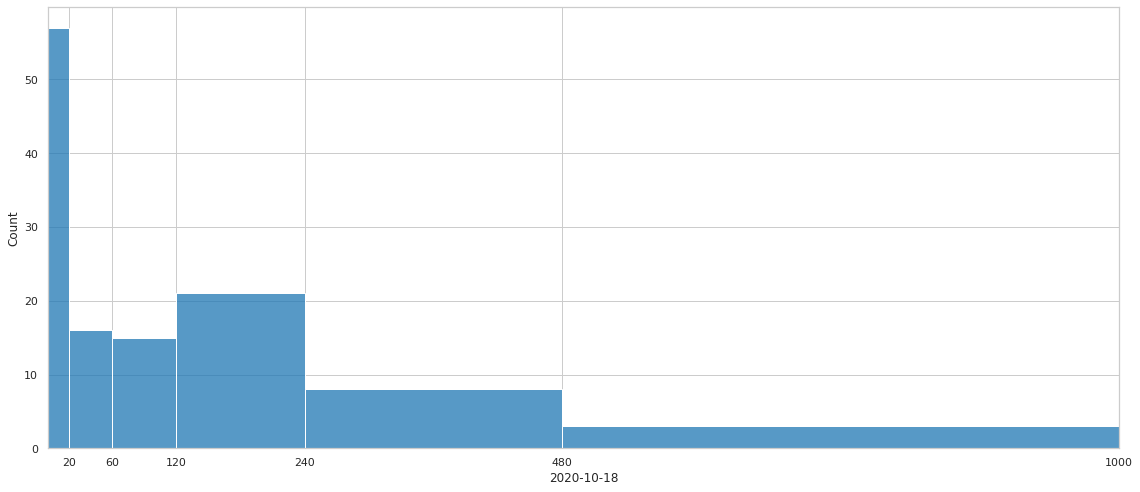

In [7]:
# Histogram
fig = plt.figure(figsize=(16,7))
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.histplot(df_14_day['2020-10-18'], bins=[0,20,60,120,240,480,1000])
plt.xticks([20,60,120,240,480,1000])
plt.xlim([0,1000])
plt.tight_layout();

In [8]:
def allocate_to_groups(x):
  if x<20:
    return '<20'
  elif x<60:
    return '20-59.9'
  elif x<120:
   return '60-119.9'
  elif x<240:
    return '120-239.9'
  elif x<480:
    return '240-479.9'
  return '>480'

In [9]:
date=df_14_day.columns[-1]
day_df=pd.DataFrame(df_14_day[date])
day_df['group']=day_df[date].apply(lambda x: allocate_to_groups(x))
day_df[day_df.group=='>480']

,2020-10-24,group
FRA,534.823375,>480
NLD,644.901191,>480
BEL,1010.102492,>480
CZE,1204.120055,>480
CHE,497.919146,>480


In [10]:
day_df.loc['ESP']

2020-10-24      395.724
group         240-479.9
Name: ESP, dtype: object

# Daily barplots

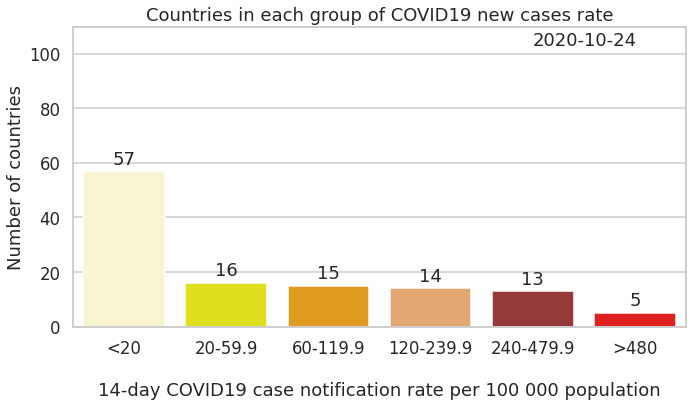

In [11]:
for date in df_14_day.columns[[-i-1 for i in range((pd.to_datetime(df_14_day.columns[-1])-pd.to_datetime('2020-04-30')).days)][::-1]]:
#for date in ['2020-05-19']:

  day_df=pd.DataFrame(df_14_day[date])
  day_df['group']=day_df[date].apply(lambda x: allocate_to_groups(x))

  fig, ax = plt.subplots(figsize=(10, 6))
  sns.set_context('talk')
  sns.set_style('whitegrid')
  plot=sns.barplot(x=['<20','20-59.9','60-119.9','120-239.9','240-479.9','>480'], 
                   y=(list(day_df.group.value_counts().values)+[0, 0])[:6], 
                   palette=['lemonchiffon','yellow','orange','sandybrown','brown','red'])
  
  for rect in plot.patches:
    height = rect.get_height().astype(int)
    ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
  ax.annotate('{}'.format(date), xy=(4,103))

  plt.title('Countries in each group of COVID19 new cases rate')
  plt.ylabel('Number of countries')
  plt.xlabel('\n14-day COVID19 case notification rate per 100 000 population')
  plt.ylim(0,110)
  plt.tight_layout()
  plt.savefig('./world_cartogram/pngs_bar/'+date, dpi=150)
  if date==df_14_day.columns[-1]: plt.show()
  plt.close();

## Make 'gif'

In [12]:
!pip install pygifsicle 
!apt install gifsicle

  Created wheel for pygifsicle: filename=pygifsicle-1.0.1-cp36-none-any.whl size=4062 sha256=daf97d461aa93612692c41c52d481250be5eb7e5d4dccb03556514f5f3b2bcdc
  Stored in directory: /root/.cache/pip/wheels/7c/27/d9/591826fc20e81ffdd7f95ac77ce0666a13fbb7b5780c7862df
Successfully built pygifsicle
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  gifsicle
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 134 kB of archives.
After this operation, 385 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 gifsicle amd64 1.91-2 [134 kB]
Fetched 134 kB in 1s (264 kB/s)
Selecting previously unselected package gifsicle.
(Reading database ... 144611 files and directories currently installed.)
Preparing to unpack .../gifsicle_1.91-2_amd64.deb ...
Unpacking gifsicle (1.91-2) ...
Setting up gifsicle (1.91-2) ...
Processing triggers fo

In [13]:
import os
import imageio
from pygifsicle import optimize

In [14]:
png_dir = '/content/drive/My Drive/TrueCue/world_cartogram/pngs_bar/'
images = []

for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

imageio.mimwrite('./world_cartogram/bar.gif', images, format='.gif', fps=20, loop=1)
optimize('./world_cartogram/bar.gif') 